In [1]:
import torch
from transformers import AutoModelForSequenceClassification, BertTokenizerFast
import requests 
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
import numpy as np

C:\Users\User\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Сначала получим рецензии на фильмы с помощью api кинопоиска.

In [2]:
def getRewiews(storage, movie_id):
    perpage_limit = 200
    token = 'ZQQ8GMN-TN54SGK-NB3MKEC-ZKB8V06' # public token, 200 requests per day
    request_pattern = "https://api.kinopoisk.dev/review?field=movieId&search={0}&limit={1}&token={2}".format(movie_id, perpage_limit, token)
    
    response = requests.get(request_pattern)
    storage.extend(response.json()['docs'])

In [3]:
movies = {
    649917: "По соображениям совести",
    964318: "Форсаж 9",
    1236063: "Довод",
    5502: "Назад в будущее 2",
    762738: "Джон Уик"
}
labels = {
    'Позитивный': 0,
    'Нейтральный': 1,
    'Негативный': 2
}

In [4]:
def setLabels(value):
    return labels.get(value)

def setMovieNames(value):
    return movies.get(value)

def removeParagraphs(text):
    return re.sub("[\r\n]", "", text)

def setLabelNames(value):
    if value == 0:
        return 'Позитивный'
    elif value == 1:
        return 'Нейтральный'
    elif value == 2:
        return 'Негативный'
    else:
        return 'unnamed'

In [5]:
reviews = []

for key in movies:
    getRewiews(reviews, key)
    
reviews = pd.json_normalize(reviews)
reviews.drop(columns=['_id','title','date','author','__v','reviewDislikes',
                      'reviewLikes','updatedAt','authorId','createdAt'], inplace=True)
reviews.rename(columns={"movieId": "movie","type": "label_name"}, inplace=True)
reviews.dropna(axis='index', how='any', inplace=True)
reviews['movie'] = reviews['movie'].apply(setMovieNames)
reviews['label'] = reviews['label_name'].apply(setLabels)
reviews['review'] = reviews['review'].apply(removeParagraphs)

reviews.shape

(733, 6)

In [6]:
reviews.head()

,userRating,id,movie,label,review,label_name
0,7.0,2968697,По соображениям совести,Позитивный,На сегодняшний день фильмов о войне снято бесч...,0
1,5.0,2923700,По соображениям совести,Негативный,Из всего фильма можно было оставить только фин...,2
2,0.0,2921664,По соображениям совести,Позитивный,"Пожалуй, именно такой вопрос люди чаще всего з...",0
3,9.5,2918088,По соображениям совести,Позитивный,Какая мысль застряла в головах у большинства л...,0
4,0.0,2917777,По соображениям совести,Негативный,"Как здесь любят упоминать, скажу, что это моя ...",2


Для классификации отзывов используем предобученную модель архитектуры BERT: https://huggingface.co/blanchefort/rubert-base-cased-sentiment

In [7]:
tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment', return_dict=True)

In [8]:
@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)

    return predicted.numpy()

In [9]:
predictions = []
counter = 1

for review in reviews['review']:
    for sentence in nltk.tokenize.sent_tokenize(review, language='russian'):
        sentence_pred = []
        sentence_pred.append(predict(sentence))
    
    mean = np.mean(sentence_pred, axis=0)
    #print('mean predictions pos|net|neg are: {0}'.format(mean))
    
    value = np.argmax(mean, axis=1).item()
    #print('most fitting class is: {0}'.format(value))
    
    predictions.append(value)
    
    print("Обработано {0} рецензий из {1}".format(counter, reviews.shape[0]))
    counter += 1
    
reviews['predicted_label'] = predictions
reviews['predicted_label_name'] = reviews['predicted_label'].apply(setLabelNames)

Обработано 1 рецензий из 733
Обработано 2 рецензий из 733
Обработано 3 рецензий из 733
Обработано 4 рецензий из 733
Обработано 5 рецензий из 733
Обработано 6 рецензий из 733
Обработано 7 рецензий из 733
Обработано 8 рецензий из 733
Обработано 9 рецензий из 733
Обработано 10 рецензий из 733
Обработано 11 рецензий из 733
Обработано 12 рецензий из 733
Обработано 13 рецензий из 733
Обработано 14 рецензий из 733
Обработано 15 рецензий из 733
Обработано 16 рецензий из 733
Обработано 17 рецензий из 733
Обработано 18 рецензий из 733
Обработано 19 рецензий из 733
Обработано 20 рецензий из 733
Обработано 21 рецензий из 733
Обработано 22 рецензий из 733
Обработано 23 рецензий из 733
Обработано 24 рецензий из 733
Обработано 25 рецензий из 733
Обработано 26 рецензий из 733
Обработано 27 рецензий из 733
Обработано 28 рецензий из 733
Обработано 29 рецензий из 733
Обработано 30 рецензий из 733
Обработано 31 рецензий из 733
Обработано 32 рецензий из 733
Обработано 33 рецензий из 733
Обработано 34 рецен

Обработано 269 рецензий из 733
Обработано 270 рецензий из 733
Обработано 271 рецензий из 733
Обработано 272 рецензий из 733
Обработано 273 рецензий из 733
Обработано 274 рецензий из 733
Обработано 275 рецензий из 733
Обработано 276 рецензий из 733
Обработано 277 рецензий из 733
Обработано 278 рецензий из 733
Обработано 279 рецензий из 733
Обработано 280 рецензий из 733
Обработано 281 рецензий из 733
Обработано 282 рецензий из 733
Обработано 283 рецензий из 733
Обработано 284 рецензий из 733
Обработано 285 рецензий из 733
Обработано 286 рецензий из 733
Обработано 287 рецензий из 733
Обработано 288 рецензий из 733
Обработано 289 рецензий из 733
Обработано 290 рецензий из 733
Обработано 291 рецензий из 733
Обработано 292 рецензий из 733
Обработано 293 рецензий из 733
Обработано 294 рецензий из 733
Обработано 295 рецензий из 733
Обработано 296 рецензий из 733
Обработано 297 рецензий из 733
Обработано 298 рецензий из 733
Обработано 299 рецензий из 733
Обработано 300 рецензий из 733
Обработа

Обработано 534 рецензий из 733
Обработано 535 рецензий из 733
Обработано 536 рецензий из 733
Обработано 537 рецензий из 733
Обработано 538 рецензий из 733
Обработано 539 рецензий из 733
Обработано 540 рецензий из 733
Обработано 541 рецензий из 733
Обработано 542 рецензий из 733
Обработано 543 рецензий из 733
Обработано 544 рецензий из 733
Обработано 545 рецензий из 733
Обработано 546 рецензий из 733
Обработано 547 рецензий из 733
Обработано 548 рецензий из 733
Обработано 549 рецензий из 733
Обработано 550 рецензий из 733
Обработано 551 рецензий из 733
Обработано 552 рецензий из 733
Обработано 553 рецензий из 733
Обработано 554 рецензий из 733
Обработано 555 рецензий из 733
Обработано 556 рецензий из 733
Обработано 557 рецензий из 733
Обработано 558 рецензий из 733
Обработано 559 рецензий из 733
Обработано 560 рецензий из 733
Обработано 561 рецензий из 733
Обработано 562 рецензий из 733
Обработано 563 рецензий из 733
Обработано 564 рецензий из 733
Обработано 565 рецензий из 733
Обработа

NameError: name 'rewiews' is not defined

<AxesSubplot: xlabel='movie', ylabel='count'>

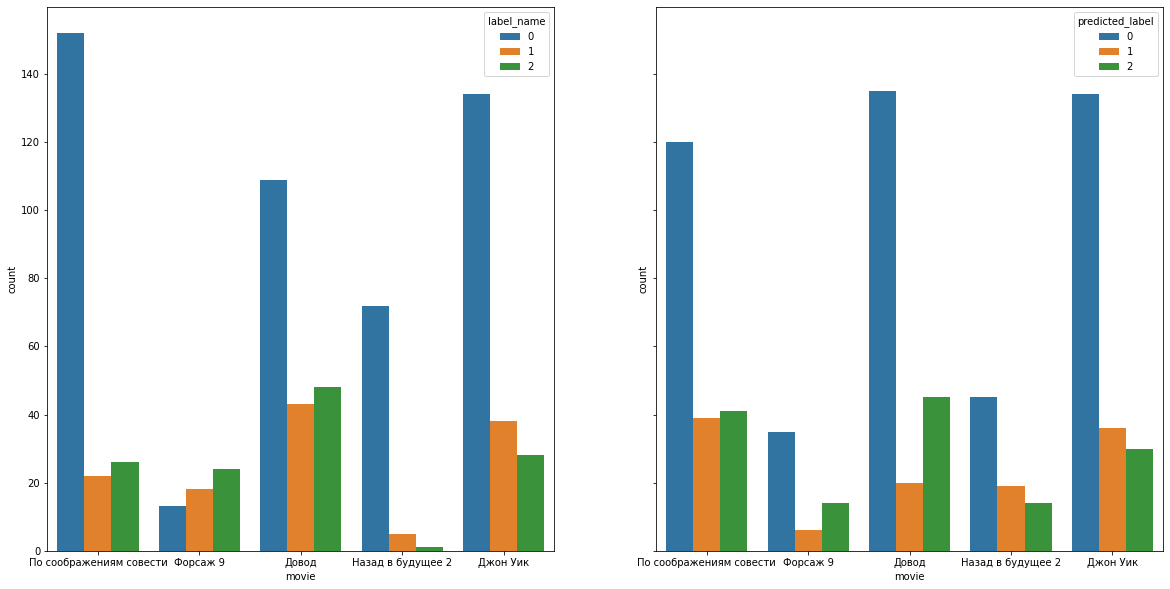

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)
sns.countplot(data=reviews, x="movie", hue="label", ax=ax[0])
sns.countplot(data=reviews, x="movie", hue="predicted_label", ax=ax[1])

При разбиении текста на предложения и усреднении предсказаний по предложениям для текста результаты получились лучше, чем для предсказаний по целому тексту.

In [15]:
f1_score(reviews['label'], reviews['predicted_label'], average='micro')

0.514324693042292